In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('brisbane_water_quality.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30894 entries, 0 to 30893
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Timestamp                                 30894 non-null  object 
 1   Record number                             30894 non-null  int64  
 2   Average Water Speed                       30874 non-null  float64
 3   Average Water Direction                   30893 non-null  float64
 4   Chlorophyll                               30309 non-null  float64
 5   Chlorophyll [quality]                     30086 non-null  float64
 6   Temperature                               25730 non-null  float64
 7   Temperature [quality]                     25550 non-null  float64
 8   Dissolved Oxygen                          26594 non-null  float64
 9   Dissolved Oxygen [quality]                26370 non-null  float64
 10  Dissolved Oxygen (%Saturation)    

In [3]:
df.shape

(30894, 20)

In [4]:
# Drop columns with quality information
df = df.drop(columns=['Dissolved Oxygen [quality]', 'Chlorophyll [quality]', 'Temperature [quality]',
                      'Dissolved Oxygen (%Saturation) [quality]', 'pH [quality]', 'Salinity [quality]',
                      'Specific Conductance [quality]', 'Turbidity [quality]', 'Record number'], errors='ignore')

In [5]:
df.shape

(30894, 11)

In [6]:
# Convert 'Timestamp' column to datetime 
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

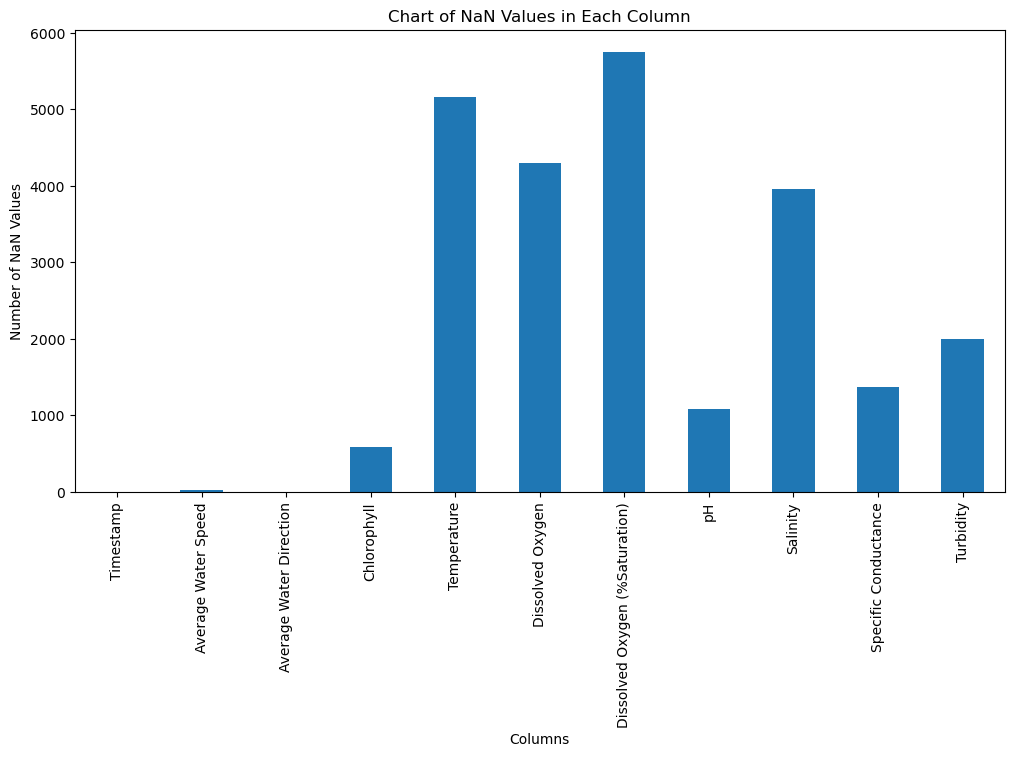

In [7]:
null_sum = df.isnull().sum()

# Plot histogram of NaN values
plt.figure(figsize=(12, 6))
null_sum.plot(kind='bar')
plt.title('Chart of NaN Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.show()

In [8]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median') #best performing after testing

# Fit the imputer on the DataFrame's numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

#OR df = df.dropna() (seemingly works better)

# Check for missing values after imputation
df.isnull().sum()

Timestamp                         0
Average Water Speed               0
Average Water Direction           0
Chlorophyll                       0
Temperature                       0
Dissolved Oxygen                  0
Dissolved Oxygen (%Saturation)    0
pH                                0
Salinity                          0
Specific Conductance              0
Turbidity                         0
dtype: int64

In [9]:
# Convert 'Timestamp' column to datetime if necessary
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Hour'] = df['Timestamp'].dt.hour
df['DayOfYear'] = df['Timestamp'].dt.dayofyear
df['Month'] = df['Timestamp'].dt.month

df.head()

,Timestamp,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,Dissolved Oxygen,Dissolved Oxygen (%Saturation),pH,Salinity,Specific Conductance,Turbidity,Hour,DayOfYear,Month
0,2023-08-04 23:00:00,4.834,73.484,1.621,20.018,7.472,101.175,8.176,35.215,53.262,2.068,23,216,8
1,2023-08-04 23:30:00,2.544,106.424,1.959,19.986,7.455,100.884,8.175,35.209,53.254,1.994,23,216,8
2,2023-08-04 23:00:00,1.260,156.755,1.620,20.001,7.430,100.571,8.171,35.207,53.252,2.030,23,216,8
3,2023-08-04 23:30:00,0.760,281.754,1.761,19.983,7.419,100.398,8.171,35.211,53.257,1.973,23,216,8
4,2023-08-04 23:00:00,3.397,244.637,1.635,19.986,7.429,100.538,8.171,35.208,53.253,1.944,23,216,8


In [10]:
duplicate_timestamps = df[df.duplicated(subset=['Timestamp'], keep=False)]
if not duplicate_timestamps.empty:
    print("Duplicate timestamps exist:")
    print(duplicate_timestamps)
else:
    print("No duplicate timestamps found.")

Duplicate timestamps exist:
                Timestamp  Average Water Speed  Average Water Direction  \
0     2023-08-04 23:00:00                4.834                   73.484   
1     2023-08-04 23:30:00                2.544                  106.424   
2     2023-08-04 23:00:00                1.260                  156.755   
3     2023-08-04 23:30:00                0.760                  281.754   
4     2023-08-04 23:00:00                3.397                  244.637   
...                   ...                  ...                      ...   
30459 2024-06-24 09:00:00               23.286                  102.621   
30603 2024-06-25 09:00:00                5.070                   29.750   
30604 2024-06-25 09:00:00                5.070                   29.750   
30748 2024-06-26 09:00:00               42.538                  212.200   
30749 2024-06-26 09:00:00               42.538                  212.200   

       Chlorophyll  Temperature  Dissolved Oxygen  \
0            1.621

In [11]:
# Remove duplicate timestamps by averaging values for duplicate timestamps
df.set_index('Timestamp', inplace=True)
water_quality_df_cleaned = df.groupby(df.index).mean()

In [12]:
water_quality_df_cleaned.shape

(30614, 13)

In [13]:
df = water_quality_df_cleaned.resample('H').mean().interpolate()

In [14]:
from scipy import stats  # Import the stats module from scipy

def remove_outliers_zscore(df, threshold=3):
    """Removes outliers from a DataFrame using the Z-score method.
    
    Args:
        df: The input DataFrame.
        threshold: The Z-score threshold for outlier detection.
    
    Returns:
        A new DataFrame with outliers removed.
    """
    df_no_outliers = df.copy()
    for col in df.select_dtypes(include=np.number):
      z_scores = np.abs(stats.zscore(df[col]))
      df_no_outliers = df_no_outliers[(z_scores < threshold)]
    return df_no_outliers


# Example usage
df_no_outliers = remove_outliers_zscore(df)

C:\Users\hankaixin\AppData\Local\Temp\ipykernel_18004\2088760766.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_no_outliers = df_no_outliers[(z_scores < threshold)]
C:\Users\hankaixin\AppData\Local\Temp\ipykernel_18004\2088760766.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_no_outliers = df_no_outliers[(z_scores < threshold)]
C:\Users\hankaixin\AppData\Local\Temp\ipykernel_18004\2088760766.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_no_outliers = df_no_outliers[(z_scores < threshold)]
C:\Users\hankaixin\AppData\Local\Temp\ipykernel_18004\2088760766.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_no_outliers = df_no_outliers[(z_scores < threshold)]
C:\Users\hankaixin\AppData\Local\Temp\ipykernel_18004\2088760766.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_no_outliers = df_no_out

In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define features (X) and target variable (y)
X = df_no_outliers.drop(columns=['Dissolved Oxygen'])
y = df_no_outliers['Dissolved Oxygen']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize scalers
scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler()
}

results = {}

for scaler_name, scaler in scalers.items():
    # Fit and transform the scaler on training data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train a Linear Regression model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Make predictions on test data
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    results[scaler_name] = mse

# Print the results
for scaler_name, mse in results.items():
    print(f'{scaler_name}: MSE = {mse}')

# Identify the best scaler
best_scaler = min(results, key=results.get)
print(f'\nBest Scaler: {best_scaler}')


MinMaxScaler: MSE = 0.06356657728872636
StandardScaler: MSE = 0.06356657728872636
RobustScaler: MSE = 0.06356657728872636

Best Scaler: MinMaxScaler


In [16]:
# # Choose the best scaler based on your previous results
best_scaler = 'StandardScaler'

# Fit and transform using the best scaler
scaler = scalers[best_scaler]
X_train_scaled = scaler.fit_transform(X_train)

Outliers detected:
Average Water Speed: 62 outliers
Chlorophyll: 108 outliers
Dissolved Oxygen: 54 outliers
Dissolved Oxygen (%Saturation): 92 outliers
pH: 9 outliers
Salinity: 74 outliers
Specific Conductance: 76 outliers
Turbidity: 171 outliers


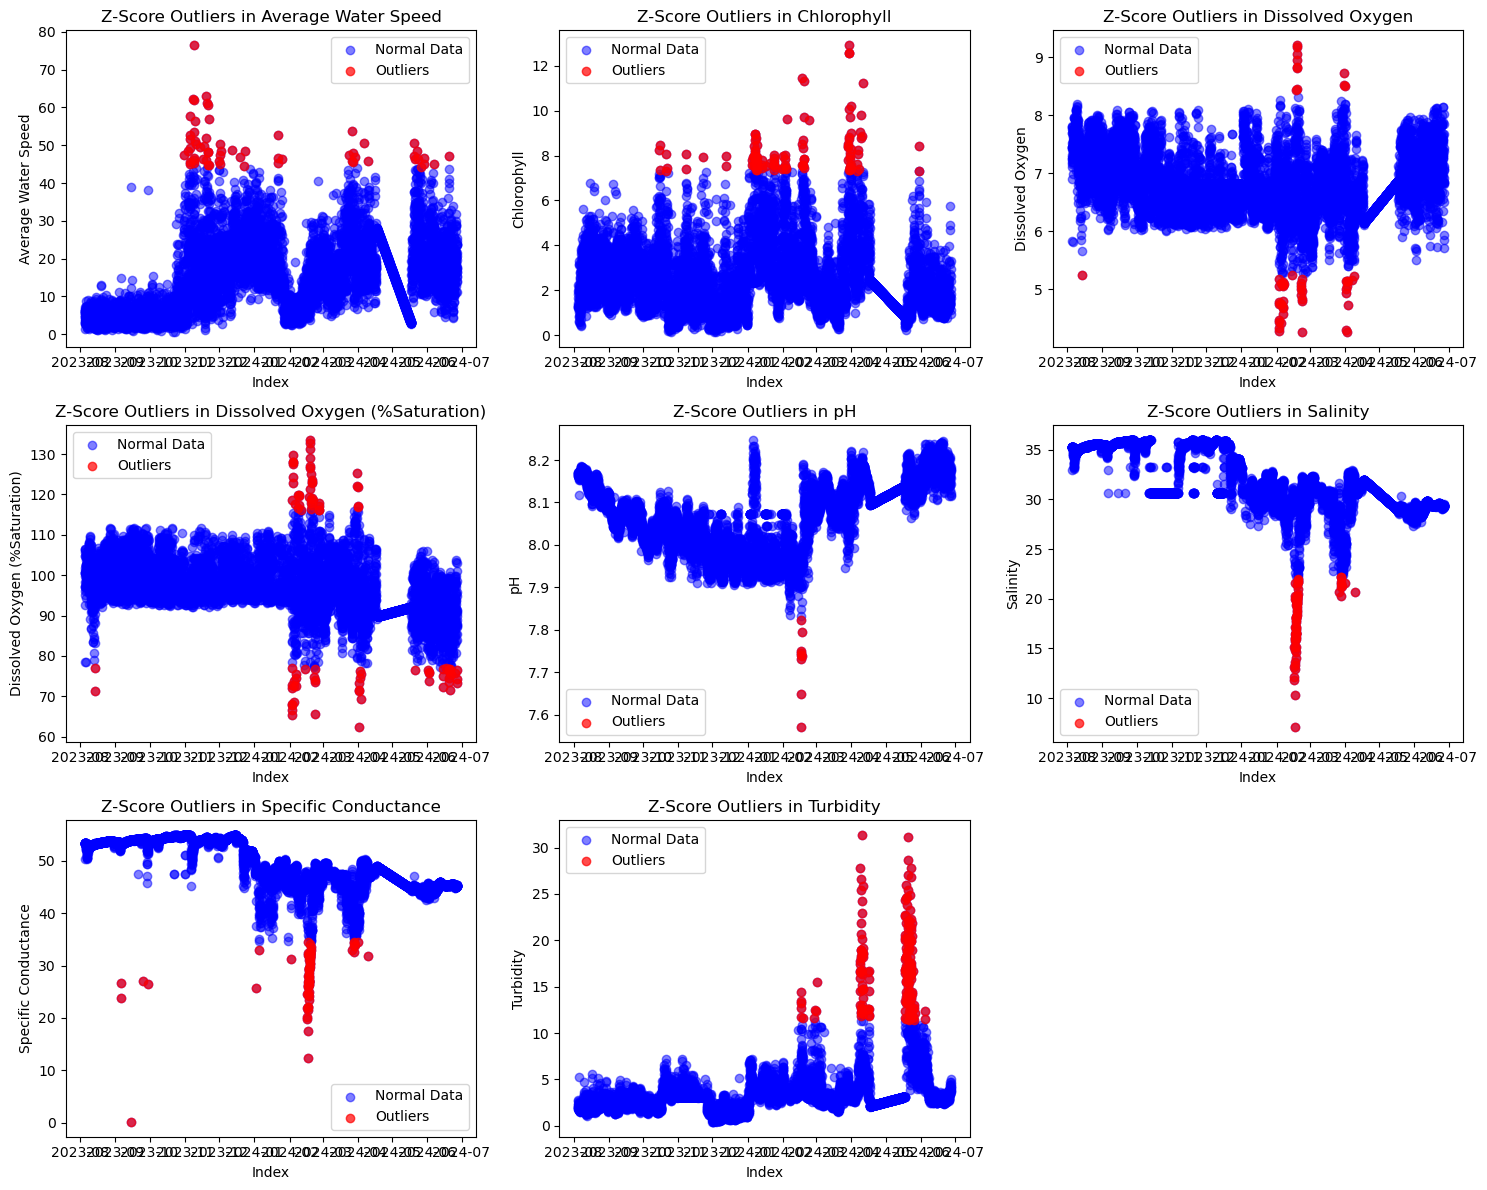


Original DataFrame shape: (7859, 13)
DataFrame shape after outlier removal: (7329, 13)


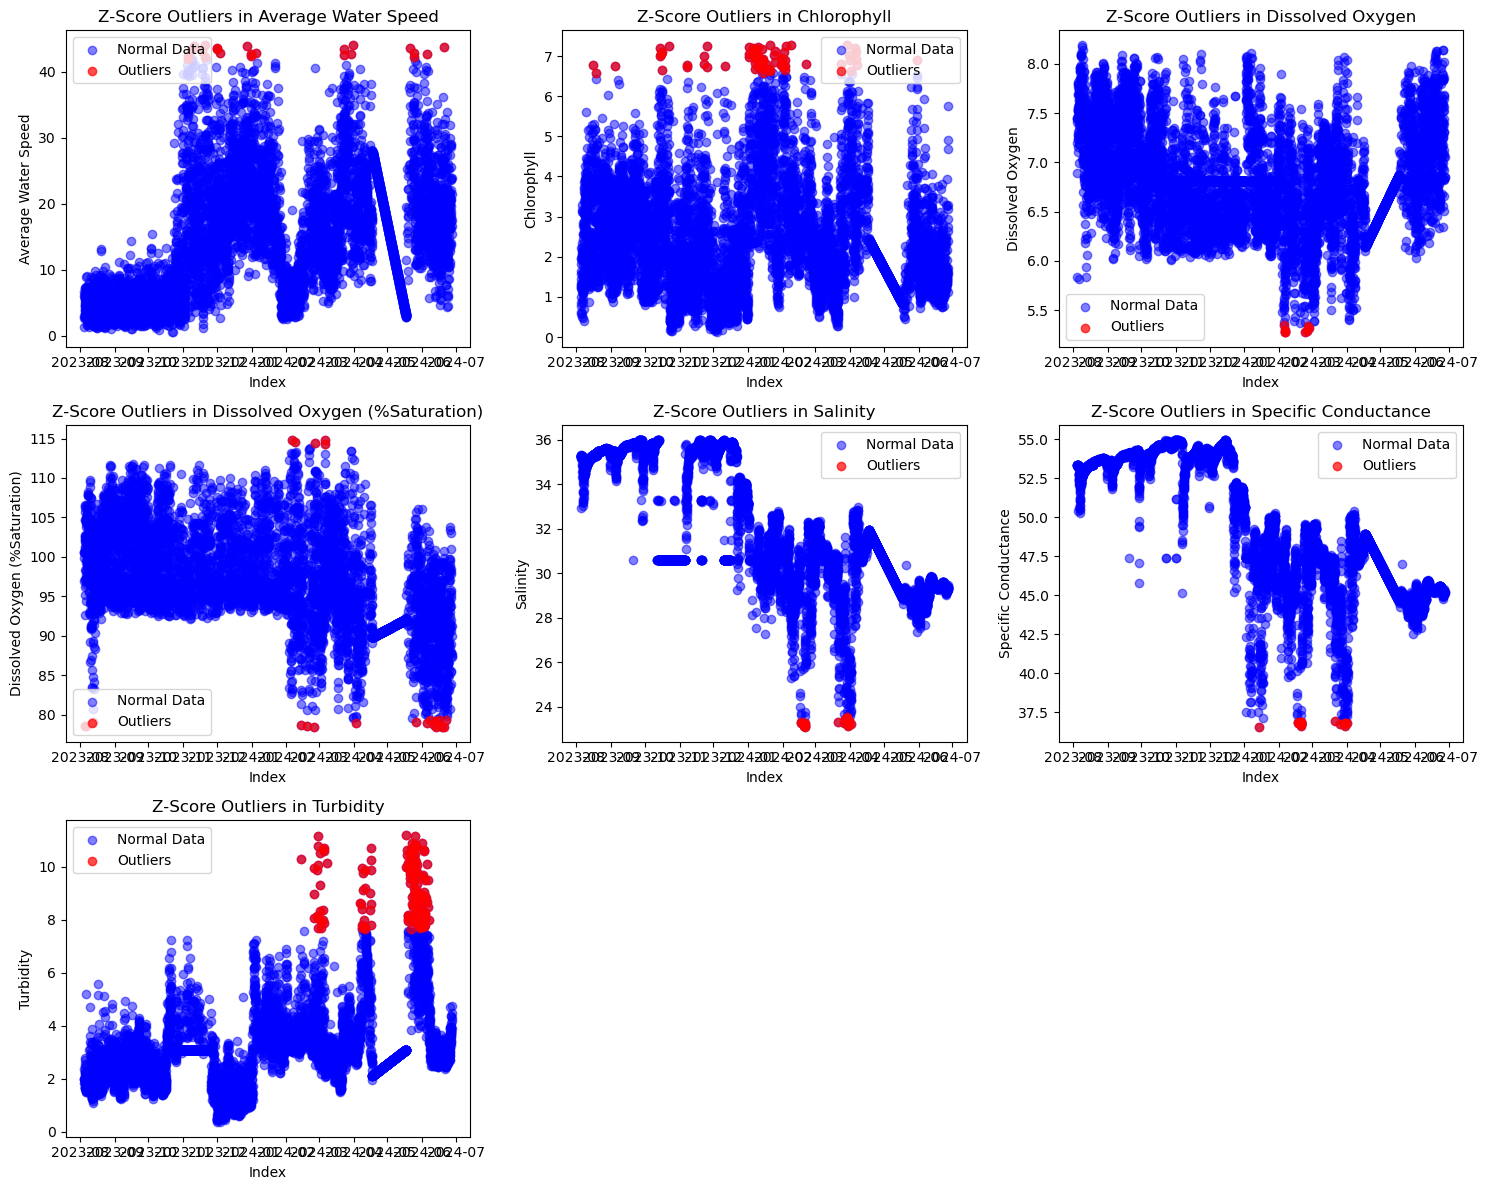

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to detect outliers using Z-score
def detect_outliers_zscore(df, threshold=3):
    """
    Detects outliers using the Z-score method and counts them per column.

    Args:
        df: The input DataFrame.
        threshold: The Z-score threshold for identifying outliers (default is 3).

    Returns:
        A dictionary with column names as keys and outlier counts as values.
        A dictionary with column names and corresponding outlier indices.
    """
    outlier_counts = {}
    outlier_indices = {}

    for col in df.select_dtypes(include=[np.number]).columns:  # Only check numeric columns
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        outliers = df[z_scores >= threshold]
        if not outliers.empty:  # Only store columns with actual outliers
            outlier_counts[col] = len(outliers)
            outlier_indices[col] = outliers.index  # Store indices for plotting

    return outlier_counts, outlier_indices

# Function to remove outliers
def remove_outliers_zscore(df, threshold=3):
    """
    Removes outliers from all numeric columns using the Z-score method.

    Args:
        df: The input DataFrame.
        threshold: The Z-score threshold for identifying outliers (default is 3).

    Returns:
        A new DataFrame with outliers removed.
    """
    df_no_outliers = df.copy()

    for col in df.select_dtypes(include=[np.number]).columns:
        z_scores = np.abs((df_no_outliers[col] - df_no_outliers[col].mean()) / df_no_outliers[col].std())
        df_no_outliers = df_no_outliers[z_scores < threshold]

    return df_no_outliers

# Function to plot Z-score outliers in a grid layout
def plot_zscore_outliers(df, outlier_indices):
    """
    Plots scatter plots in a grid layout to visualize Z-score outliers for all detected columns.

    Args:
        df: The input DataFrame.
        outlier_indices: A dictionary with column names as keys and outlier indices as values.
    """
    cols_with_outliers = list(outlier_indices.keys())
    num_cols = len(cols_with_outliers)

    if num_cols == 0:
        print("No outliers detected to plot.")
        return

    # Set grid size (aiming for a square or balanced layout)
    cols_per_row = min(3, num_cols)  # Max 3 columns per row
    rows = (num_cols // cols_per_row) + (num_cols % cols_per_row > 0)

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 4 * rows))
    axes = np.array(axes).flatten()  # Flatten in case of 1D or asymmetric layout

    for ax, col in zip(axes, cols_with_outliers):
        ax.scatter(df.index, df[col], label="Normal Data", color="blue", alpha=0.5)
        ax.scatter(outlier_indices[col], df.loc[outlier_indices[col], col], label="Outliers", color="red", alpha=0.7)
        ax.set_title(f"Z-Score Outliers in {col}")
        ax.set_xlabel("Index")
        ax.set_ylabel(col)
        ax.legend()

    # Hide any unused subplots
    for i in range(num_cols, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# Example usage:
# Detect and print outliers for all numeric columns
outliers_info, outlier_indices = detect_outliers_zscore(df)
print("Outliers detected:")
for col, count in outliers_info.items():
    print(f"{col}: {count} outliers")

# Plot detected outliers in a grid layout
plot_zscore_outliers(df, outlier_indices)

# Remove outliers
df_cleaned = remove_outliers_zscore(df)

# Print shape before and after outlier removal
print("\nOriginal DataFrame shape:", df.shape)
print("DataFrame shape after outlier removal:", df_cleaned.shape)

# Detect and plot outliers again to confirm removal
outliers_info_cleaned, outlier_indices_cleaned = detect_outliers_zscore(df_cleaned)
plot_zscore_outliers(df_cleaned, outlier_indices_cleaned)


In [19]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.mixture import GaussianMixture

# Initialize and train the Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_train_scaled)

# Predict cluster assignments for the test data
predictions = gmm.predict(scaler.transform(X_test))

# Calculate the silhouette score
silhouette = silhouette_score(scaler.transform(X_test), predictions)
print(f"Silhouette Score: {silhouette}") #higher

# Calculate the Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(scaler.transform(X_test), predictions)
print(f"Davies-Bouldin Index: {davies_bouldin}") #lower

calinski_harabasz = calinski_harabasz_score(scaler.transform(X_test), predictions) 
print(f"Calinski-Harabasz Index: {calinski_harabasz}") #higher

Silhouette Score: 0.2454640503661635
Davies-Bouldin Index: 1.7076321415169948
Calinski-Harabasz Index: 457.5230677852675


In [20]:
#pip install hdbscan

In [27]:
from sklearn.cluster import OPTICS

# Assuming X_train_scaled is already defined from the previous code

# Initialize and train the OPTICS model
optics_model = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05) # You can adjust the parameters
optics_model.fit(X_train_scaled)

# Predict cluster assignments for the test data
predictions = optics_model.fit_predict(scaler.transform(X_test))

# Calculate the silhouette score
silhouette = silhouette_score(scaler.transform(X_test), predictions)
print(f"Silhouette Score: {silhouette}")

# Calculate the Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(scaler.transform(X_test), predictions)
print(f"Davies-Bouldin Index: {davies_bouldin}")

calinski_harabasz = calinski_harabasz_score(scaler.transform(X_test), predictions) 
print(f"Calinski-Harabasz Index: {calinski_harabasz}") #higher

Silhouette Score: 0.034671896073940583
Davies-Bouldin Index: 1.80994746060967
Calinski-Harabasz Index: 342.50343967308527


In [21]:
import hdbscan

# Initialize and train the HDBSCAN model
clusterer = hdbscan.HDBSCAN(min_cluster_size=10,  # Adjust this parameter as needed
                           gen_min_span_tree=True)  # Optional: Generate minimum spanning tree
clusterer.fit(X_train_scaled)

# Get cluster labels for the training data
train_labels = clusterer.labels_

# Get cluster labels for the test data
test_labels = clusterer.fit_predict(scaler.transform(X_test)) #or clusterer.approximate_predict(scaler.transform(X_test))

# Calculate the silhouette score
silhouette = silhouette_score(scaler.transform(X_test), test_labels)
print(f"Silhouette Score: {silhouette}")

# Calculate the Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(scaler.transform(X_test), test_labels)
print(f"Davies-Bouldin Index: {davies_bouldin}")

calinski_harabasz = calinski_harabasz_score(scaler.transform(X_test), predictions) 
print(f"Calinski-Harabasz Index: {calinski_harabasz}") #higher

Silhouette Score: 0.049214301563037036
Davies-Bouldin Index: 1.938229366671847
Calinski-Harabasz Index: 457.5230677852675


In [22]:
from sklearn.cluster import SpectralClustering

# Assuming X_train_scaled is already defined from the previous code

# Initialize and train the Spectral Clustering model
spectral_clustering = SpectralClustering(n_clusters=3, assign_labels='kmeans', random_state=42) #n_clusters should be tuned
spectral_clustering.fit(X_train_scaled)

# Predict cluster assignments for the test data
predictions = spectral_clustering.fit_predict(scaler.transform(X_test))

# Calculate the silhouette score
silhouette = silhouette_score(scaler.transform(X_test), predictions)
print(f"Silhouette Score: {silhouette}")

# Calculate the Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(scaler.transform(X_test), predictions)
print(f"Davies-Bouldin Index: {davies_bouldin}")

calinski_harabasz = calinski_harabasz_score(scaler.transform(X_test), predictions) 
print(f"Calinski-Harabasz Index: {calinski_harabasz}") #higher

Silhouette Score: 0.25684626747982675
Davies-Bouldin Index: 1.6222515525146612
Calinski-Harabasz Index: 447.5412090765174


C:\Users\hankaixin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [29]:
# prompt: train clustering model for  SK-Medoids (PAM - Partitioning Around Medoids)

# Install scikit-learn-extra if you haven't already
!pip install scikit-learn-extra

from sklearn_extra.cluster import KMedoids

# Assuming X_train_scaled is already defined from the previous code

# Initialize and train the K-Medoids model
kmedoids = KMedoids(n_clusters=3, random_state=42)  # You can change the number of clusters (n_clusters)
kmedoids.fit(X_train_scaled)

# Predict cluster assignments for the test data
predictions = kmedoids.predict(scaler.transform(X_test))

# Calculate the silhouette score
silhouette = silhouette_score(scaler.transform(X_test), predictions)
print(f"Silhouette Score: {silhouette}")

# Calculate the Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(scaler.transform(X_test), predictions)
print(f"Davies-Bouldin Index: {davies_bouldin}")

calinski_harabasz = calinski_harabasz_score(scaler.transform(X_test), predictions) 
print(f"Calinski-Harabasz Index: {calinski_harabasz}") #higher

Silhouette Score: 0.23516094395908468
Davies-Bouldin Index: 1.685353193080721
Calinski-Harabasz Index: 459.03763391131116


In [25]:
# prompt: train BIRCH model for clustering

from sklearn.cluster import Birch

# Initialize and train the BIRCH model
birch_model = Birch(n_clusters=3) # You can adjust the number of clusters
birch_model.fit(X_train_scaled)

# Predict cluster assignments for the test data
predictions = birch_model.predict(scaler.transform(X_test))

# Calculate the silhouette score
silhouette = silhouette_score(scaler.transform(X_test), predictions)
print(f"Silhouette Score: {silhouette}")

# Calculate the Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(scaler.transform(X_test), predictions)
print(f"Davies-Bouldin Index: {davies_bouldin}")

calinski_harabasz = calinski_harabasz_score(scaler.transform(X_test), predictions) 
print(f"Calinski-Harabasz Index: {calinski_harabasz}") #higher

Silhouette Score: 0.25799956951185365
Davies-Bouldin Index: 1.5278680193985223
Calinski-Harabasz Index: 430.33840333599824
